# 0. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import pyspark as sp
import findspark

from pyspark.sql import SparkSession

# 1. Find Spark

Adding pyspark to sys.path at runtime using the library findspark

In [2]:
findspark.init()
findspark.find()

'C:\\spark-3.4.1-bin-hadoop3'

# 2. Creating SparkSession

One aspect of the explanation why SparkSession is preferable over SparkContext in SparkSession Vs SparkContext battle is that SparkSession unifies all of Spark’s numerous contexts, removing the developer’s need to worry about generating separate contexts.

In [3]:
#Create the SparkSession
my_spark = SparkSession.builder.getOrCreate()

#print the session
print(my_spark)

# 3. Dataset overview

In [4]:
df = my_spark.read.csv('2017_StPaul_MN_Real_Estate.csv', header=True)
df.columns

['No.',
 'MLSID',
 'StreetNumberNumeric',
 'streetaddress',
 'STREETNAME',
 'PostalCode',
 'StateOrProvince',
 'City',
 'SalesClosePrice',
 'LISTDATE',
 'LISTPRICE',
 'LISTTYPE',
 'OriginalListPrice',
 'PricePerTSFT',
 'FOUNDATIONSIZE',
 'FENCE',
 'MapLetter',
 'LotSizeDimensions',
 'SchoolDistrictNumber',
 'DAYSONMARKET',
 'offmarketdate',
 'Fireplaces',
 'RoomArea4',
 'roomtype',
 'ROOF',
 'RoomFloor4',
 'PotentialShortSale',
 'PoolDescription',
 'PDOM',
 'GarageDescription',
 'SQFTABOVEGROUND',
 'Taxes',
 'RoomFloor1',
 'RoomArea1',
 'TAXWITHASSESSMENTS',
 'TAXYEAR',
 'LivingArea',
 'UNITNUMBER',
 'YEARBUILT',
 'ZONING',
 'STYLE',
 'ACRES',
 'CoolingDescription',
 'APPLIANCES',
 'backonmarketdate',
 'ROOMFAMILYCHAR',
 'RoomArea3',
 'EXTERIOR',
 'RoomFloor3',
 'RoomFloor2',
 'RoomArea2',
 'DiningRoomDescription',
 'BASEMENT',
 'BathsFull',
 'BathsHalf',
 'BATHQUARTER',
 'BATHSTHREEQUARTER',
 'Class',
 'BATHSTOTAL',
 'BATHDESC',
 'RoomArea5',
 'RoomFloor5',
 'RoomArea6',
 'RoomFloor6'

In [5]:
# Select our dependent variable
Y_df = df.select(['SalesClosePrice'])

# Display summary statistics
Y_df.describe().show()

+-------+------------------+
|summary|   SalesClosePrice|
+-------+------------------+
|  count|              5000|
|   mean|       262804.4668|
| stddev|140559.82591998563|
|    min|            100000|
|    max|             99900|
+-------+------------------+



# 4. Preprocessing data I

In [6]:
#Check data of the feature to predict 
df.select(["SalesClosePrice"]).dtypes

[('SalesClosePrice', 'string')]

In [7]:
# convert the data type of SalesClosePrice to integer
df = df.withColumn("SalesClosePrice", df.SalesClosePrice.cast("integer"))

In [8]:
#Check again the type after converting it.
df.select(["SalesClosePrice"]).dtypes

[('SalesClosePrice', 'int')]

In [9]:
df.select('SalesClosePrice').describe().show()

+-------+------------------+
|summary|   SalesClosePrice|
+-------+------------------+
|  count|              5000|
|   mean|       262804.4668|
| stddev|140559.82591998563|
|    min|             48000|
|    max|           1700000|
+-------+------------------+



In [10]:
#Modifying some types of key variables
df = df.withColumn("AssessedValuation", df.AssessedValuation.cast("double"))
df = df.withColumn("AssociationFee", df.AssociationFee.cast("bigint"))
df = df.withColumn("SQFTBELOWGROUND", df.SQFTBELOWGROUND.cast("bigint"))

In [11]:
#modifying name of column to capital letters
required_dtypes = [('NO', 'bigint'),
 ('MLSID', 'string'),
 ('STREETNUMBERNUMERIC', 'bigint'),
 ('STREETADDRESS', 'string'),
 ('STREETNAME', 'string'),
 ('POSTALCODE', 'bigint'),
 ('STATEORPROVINCE', 'string'),
 ('CITY', 'string'),
 ('SALESCLOSEPRICE', 'bigint'),
 ('LISTDATE', 'string'),
 ('LISTPRICE', 'bigint'),
 ('LISTTYPE', 'string'),
 ('ORIGINALLISTPRICE', 'bigint'),
 ('PRICEPERTSFT', 'double'),
 ('FOUNDATIONSIZE', 'bigint'),
 ('FENCE', 'string'),
 ('MAPLETTER', 'string'),
 ('LOTSIZEDIMENSIONS', 'string'),
 ('SCHOOLDISTRICTNUMBER', 'string'),
 ('DAYSONMARKET', 'bigint'),
 ('OFFMARKETDATE', 'string'),
 ('FIREPLACES', 'bigint'),
 ('ROOMAREA4', 'string'),
 ('ROOMTYPE', 'string'),
 ('ROOF', 'string'),
 ('ROOMFLOOR4', 'string'),
 ('POTENTIALSHORTSALE', 'string'),
 ('POOLDESCRIPTION', 'string'),
 ('PDOM', 'bigint'),
 ('GARAGEDESCRIPTION', 'string'),
 ('SQFTABOVEGROUND', 'bigint'),
 ('TAXES', 'bigint'),
 ('ROOMFLOOR1', 'string'),
 ('ROOMAREA1', 'string'),
 ('TAXWITHASSESSMENTS', 'double'),
 ('TAXYEAR', 'bigint'),
 ('LIVINGAREA', 'bigint'),
 ('UNITNUMBER', 'string'),
 ('YEARBUILT', 'bigint'),
 ('ZONING', 'string'),
 ('STYLE', 'string'),
 ('ACRES', 'double'),
 ('COOLINGDESCRIPTION', 'string'),
 ('APPLIANCES', 'string'),
 ('BACKONMARKETDATE', 'double'),
 ('ROOMFAMILYCHAR', 'string'),
 ('ROOMAREA3', 'string'),
 ('EXTERIOR', 'string'),
 ('ROOMFLOOR3', 'string'),
 ('ROOMFLOOR2', 'string'),
 ('ROOMAREA2', 'string'),
 ('DININGROOMDESCRIPTION', 'string'),
 ('BASEMENT', 'string'),
 ('BATHSFULL', 'bigint'),
 ('BATHSHALF', 'bigint'),
 ('BATHQUARTER', 'bigint'),
 ('BATHSTHREEQUARTER', 'double'),
 ('CLASS', 'string'),
 ('BATHSTOTAL', 'bigint'),
 ('BATHDESC', 'string'),
 ('ROOMAREA5', 'string'),
 ('ROOMFLOOR5', 'string'),
 ('ROOMAREA6', 'string'),
 ('ROOMFLOOR6', 'string'),
 ('ROOMAREA7', 'string'),
 ('ROOMFLOOR7', 'string'),
 ('ROOMAREA8', 'string'),
 ('ROOMFLOOR8', 'string'),
 ('BEDROOMS', 'bigint'),
 ('SQFTBELOWGROUND', 'bigint'),
 ('ASSUMABLEMORTGAGE', 'string'),
 ('ASSOCIATIONFEE', 'bigint'),
 ('ASSESSMENTPENDING', 'string'),
 ('ASSESSEDVALUATION', 'double')]

In [12]:
old_columns = df.columns

In [13]:
new_columns = [c for c, d in required_dtypes]

In [14]:
for n, o in zip(new_columns, old_columns): 
    df = df.withColumnRenamed(o, n)

In [15]:
#Checking the transformation of column names to capital letters
df.dtypes

[('NO', 'string'),
 ('MLSID', 'string'),
 ('STREETNUMBERNUMERIC', 'string'),
 ('STREETADDRESS', 'string'),
 ('STREETNAME', 'string'),
 ('POSTALCODE', 'string'),
 ('STATEORPROVINCE', 'string'),
 ('CITY', 'string'),
 ('SALESCLOSEPRICE', 'int'),
 ('LISTDATE', 'string'),
 ('LISTPRICE', 'string'),
 ('LISTTYPE', 'string'),
 ('ORIGINALLISTPRICE', 'string'),
 ('PRICEPERTSFT', 'string'),
 ('FOUNDATIONSIZE', 'string'),
 ('FENCE', 'string'),
 ('MAPLETTER', 'string'),
 ('LOTSIZEDIMENSIONS', 'string'),
 ('SCHOOLDISTRICTNUMBER', 'string'),
 ('DAYSONMARKET', 'string'),
 ('OFFMARKETDATE', 'string'),
 ('FIREPLACES', 'string'),
 ('ROOMAREA4', 'string'),
 ('ROOMTYPE', 'string'),
 ('ROOF', 'string'),
 ('ROOMFLOOR4', 'string'),
 ('POTENTIALSHORTSALE', 'string'),
 ('POOLDESCRIPTION', 'string'),
 ('PDOM', 'string'),
 ('GARAGEDESCRIPTION', 'string'),
 ('SQFTABOVEGROUND', 'string'),
 ('TAXES', 'string'),
 ('ROOMFLOOR1', 'string'),
 ('ROOMAREA1', 'string'),
 ('TAXWITHASSESSMENTS', 'string'),
 ('TAXYEAR', 'strin

In [16]:
for required_type, current_column in zip(required_dtypes, df.columns):
    # since the required and current column names are the exact order we can do:
    if required_type[1] != 'string':
        df = df.withColumn(current_column, df["{:}".format(current_column)].cast(required_type[1]))

In [17]:
df.dtypes

[('NO', 'bigint'),
 ('MLSID', 'string'),
 ('STREETNUMBERNUMERIC', 'bigint'),
 ('STREETADDRESS', 'string'),
 ('STREETNAME', 'string'),
 ('POSTALCODE', 'bigint'),
 ('STATEORPROVINCE', 'string'),
 ('CITY', 'string'),
 ('SALESCLOSEPRICE', 'bigint'),
 ('LISTDATE', 'string'),
 ('LISTPRICE', 'bigint'),
 ('LISTTYPE', 'string'),
 ('ORIGINALLISTPRICE', 'bigint'),
 ('PRICEPERTSFT', 'double'),
 ('FOUNDATIONSIZE', 'bigint'),
 ('FENCE', 'string'),
 ('MAPLETTER', 'string'),
 ('LOTSIZEDIMENSIONS', 'string'),
 ('SCHOOLDISTRICTNUMBER', 'string'),
 ('DAYSONMARKET', 'bigint'),
 ('OFFMARKETDATE', 'string'),
 ('FIREPLACES', 'bigint'),
 ('ROOMAREA4', 'string'),
 ('ROOMTYPE', 'string'),
 ('ROOF', 'string'),
 ('ROOMFLOOR4', 'string'),
 ('POTENTIALSHORTSALE', 'string'),
 ('POOLDESCRIPTION', 'string'),
 ('PDOM', 'bigint'),
 ('GARAGEDESCRIPTION', 'string'),
 ('SQFTABOVEGROUND', 'bigint'),
 ('TAXES', 'bigint'),
 ('ROOMFLOOR1', 'string'),
 ('ROOMAREA1', 'string'),
 ('TAXWITHASSESSMENTS', 'double'),
 ('TAXYEAR', 'bi

In [18]:
check_columns = ['FOUNDATIONSIZE',
 'DAYSONMARKET',
 'FIREPLACES',
 'PDOM',
 'SQFTABOVEGROUND',
 'TAXES',
 'TAXWITHASSESSMENTS',
 'TAXYEAR',
 'LIVINGAREA',
 'YEARBUILT',
 'ACRES',
 'BACKONMARKETDATE',
 'BATHSFULL',
 'BATHSHALF',
 'BATHQUARTER',
 'BATHSTHREEQUARTER',
 'BATHSTOTAL',
 'BEDROOMS',
 'SQFTBELOWGROUND',
 'ASSOCIATIONFEE',
 'ASSESSEDVALUATION']

In [19]:
# Name and value of col with max corr
corr_max = 0
corr_max_col = check_columns[0]

# Loop to check all columns contained in list
for col in check_columns:
    # Check the correlation of a pair of columns
    corr_val = df.corr(col, 'SALESCLOSEPRICE')
    # Logic to compare corr_max with current corr_val
    if corr_val > corr_max:
        # Update the column name and corr value
        corr_max = corr_val
        corr_max_col = col

print(corr_max_col)

LIVINGAREA


# 5. Visualizations

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

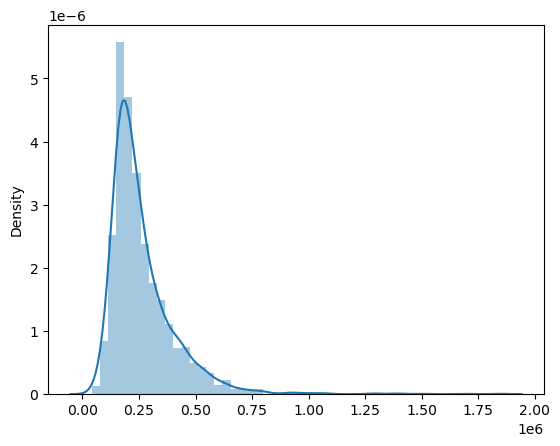

[Row(skewness(LISTPRICE)=2.790448093916559)]


In [21]:
# Select a single column and sample and convert to pandas
# sample 50% and not use replacement and setting the random seed to 42.
sample_df = df.select(['LISTPRICE']).sample(False, .5, 42)
pandas_df = sample_df.toPandas()

# Plot distribution of pandas_df and display plot
sns.distplot(pandas_df)
plt.show()

# Import skewness function
from pyspark.sql.functions import skewness

# Compute and print skewness of LISTPRICE
print(df.agg({'LISTPRICE': 'skewness'}).collect())

In [22]:
# Select a the relevant columns and sample
sample_df = df.select(['SALESCLOSEPRICE','LIVINGAREA']).sample(False, .5, 42)

# Convert to pandas dataframe
pandas_df = sample_df.toPandas()

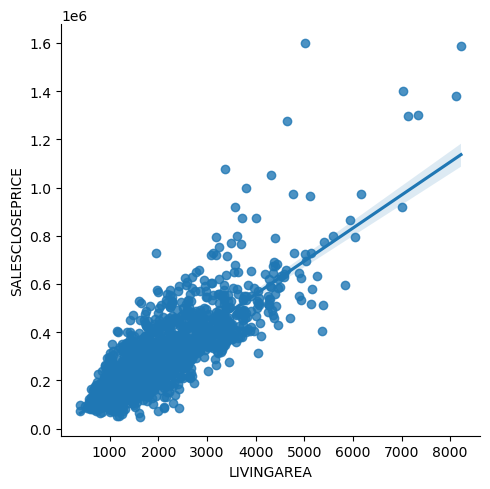

In [23]:
# Linear model plot of pandas_df
sns.lmplot(x='LIVINGAREA', y='SALESCLOSEPRICE', data=pandas_df)

We can see a relation. If Livingarea increase, the salescloseprice also increases.

# 6. Preprocessing data II

### 6.1 Dropping a list of columns

In [24]:
# List of columns to remove from dataset
cols_to_drop = ['STREETNUMBERNUMERIC', 'LOTSIZEDIMENSIONS']

# Drop columns in list
df = df.drop(*cols_to_drop)

### 6.2 Using text filters to remove records

In [25]:
# Inspect unique values in the column 'ASSUMABLEMORTGAGE'
df.select(['ASSUMABLEMORTGAGE']).distinct().show()

+-------------------+
|  ASSUMABLEMORTGAGE|
+-------------------+
|  Yes w/ Qualifying|
| Information Coming|
|               null|
|Yes w/No Qualifying|
|      Not Assumable|
+-------------------+



In [26]:
df.groupBy('ASSUMABLEMORTGAGE').count().show()

+-------------------+-----+
|  ASSUMABLEMORTGAGE|count|
+-------------------+-----+
|  Yes w/ Qualifying|   21|
| Information Coming|   29|
|               null| 3104|
|Yes w/No Qualifying|    3|
|      Not Assumable| 1843|
+-------------------+-----+



In [27]:
df.count()

5000

In [28]:
# List of possible values containing 'yes'
yes_values = ['Yes w/ Qualifying', 'Yes w/No Qualifying']

# Filter the text values out of df but keep null values
text_filter = ~df['ASSUMABLEMORTGAGE'].isin(yes_values) | df['ASSUMABLEMORTGAGE'].isNull()
df = df.where(text_filter)

In [29]:
df.count()

4976

In [30]:
# We kept values that were null and values that where not in the list provided.
df.groupBy('ASSUMABLEMORTGAGE').count().show()

+------------------+-----+
| ASSUMABLEMORTGAGE|count|
+------------------+-----+
|Information Coming|   29|
|              null| 3104|
|     Not Assumable| 1843|
+------------------+-----+



### 6.3 Filtering numeric fields conditionally

In [31]:
#Changing column to his log value.
from pyspark.sql.functions import log
df = df.withColumn('log_SalesClosePrice', log('SalesClosePrice'))

In [32]:
# Select a the relevant columns and sample
sample_df = df.select(['log_SalesClosePrice'])

# Convert to pandas dataframe
pandas_df = sample_df.toPandas()

In [33]:
pandas_df.head()

,log_SalesClosePrice
0,11.870600
1,12.154779
2,12.323856
3,12.487485
4,12.428816


<AxesSubplot:xlabel='log_SalesClosePrice'>

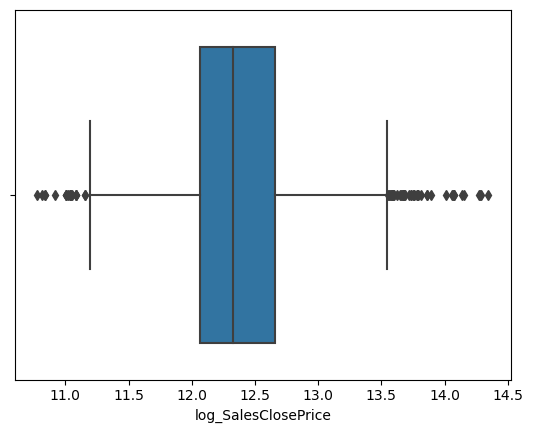

In [34]:
sns.boxplot(x=pandas_df["log_SalesClosePrice"])

In [35]:
from pyspark.sql.functions import mean, stddev

# Calculate values used for outlier filtering
mean_val = df.agg({'log_SalesClosePrice': 'mean'}).collect()[0][0]
stddev_val = df.agg({'log_SalesClosePrice': 'stddev'}).collect()[0][0]

In [36]:
# Create three standard deviation (μ ± 3σ) lower and upper bounds for data
low_bound = mean_val - (3 * stddev_val)
hi_bound = mean_val + (3 * stddev_val)

In [37]:
df.count()

4976

In [38]:
# Filter the data to fit between the lower and upper bounds
df = df.where((df['log_SalesClosePrice'] < hi_bound) & (df['log_SalesClosePrice'] > low_bound))

In [39]:
df.count()

4946

<AxesSubplot:xlabel='log_SalesClosePrice'>

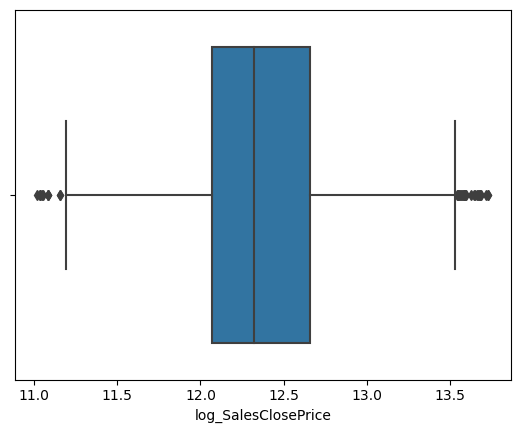

In [40]:
# Check that we have deleted outliers
sample_df = df.select(['log_SalesClosePrice'])
pandas_df = sample_df.toPandas()
sns.boxplot(x=pandas_df["log_SalesClosePrice"])

### 6.4 Custom Percentage Scaling

Creating a manual scaling of the Daysonmarket column

In [41]:
from pyspark.sql.functions import round

In [42]:
# Define max and min values and collect them
max_days = df.agg({'DAYSONMARKET': 'max'}).collect()[0][0]
min_days = df.agg({'DAYSONMARKET': 'min'}).collect()[0][0]

In [43]:
# Create a new column based off the scaled data using the formula manually
df = df.withColumn('percentage_scaled_days', 
                  round((df['DAYSONMARKET'] - min_days) / (max_days - min_days)) * 100)


In [44]:
# Calc max and min for new column
print(df.agg({'percentage_scaled_days': 'max'}).collect())
print(df.agg({'percentage_scaled_days': 'min'}).collect())

[Row(max(percentage_scaled_days)=100.0)]
[Row(min(percentage_scaled_days)=0.0)]


<AxesSubplot:xlabel='DAYSONMARKET'>

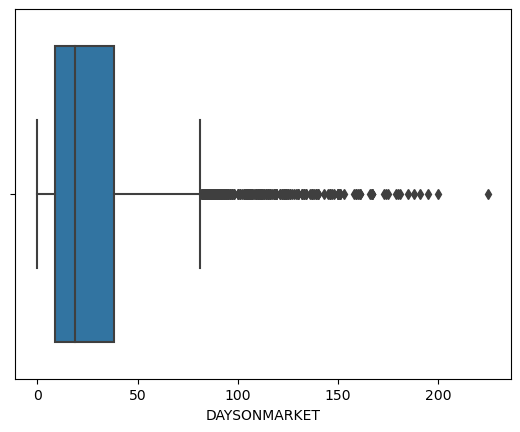

In [45]:
sample_df = df.select(['DAYSONMARKET'])
pandas_df = sample_df.toPandas()
sns.boxplot(x=pandas_df["DAYSONMARKET"])

<AxesSubplot:xlabel='percentage_scaled_days'>

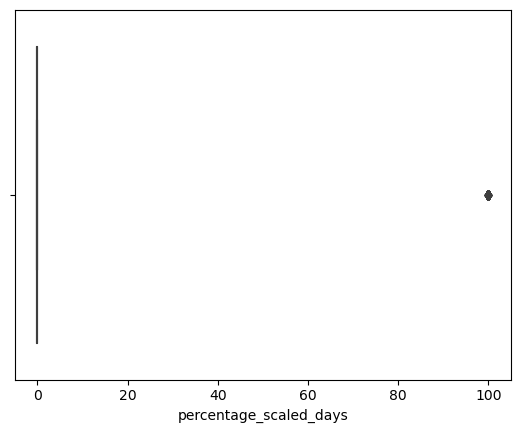

In [46]:
sample_df = df.select(['percentage_scaled_days'])
pandas_df = sample_df.toPandas()
sns.boxplot(x=pandas_df["percentage_scaled_days"])

### 6.5 Scaling your scalers

Creating a function that will scale automatically the desired features.

In [47]:
def min_max_scaler(df, cols_to_scale):
    # Takes a dataframe and list of columns to minmax scale. Returns a dataframe.
    for col in cols_to_scale:
        # Define min and max values and collect them
        max_days = df.agg({col: 'max'}).collect()[0][0]
        min_days = df.agg({col: 'min'}).collect()[0][0]
        new_column_name = 'scaled_' + col
        # Create a new column based off the scaled data
        df = df.withColumn(new_column_name, 
                          (df[col] - min_days) / (max_days - min_days))
    return df

In [48]:
df = min_max_scaler(df, ['FOUNDATIONSIZE', 'DAYSONMARKET', 'FIREPLACES'])

In [49]:
# Show that our data is now between 0 and 1
df[['DAYSONMARKET', 'scaled_DAYSONMARKET']].show()

+------------+--------------------+
|DAYSONMARKET| scaled_DAYSONMARKET|
+------------+--------------------+
|          10|0.044444444444444446|
|           4|0.017777777777777778|
|          28| 0.12444444444444444|
|          19| 0.08444444444444445|
|          21| 0.09333333333333334|
|          17| 0.07555555555555556|
|          32| 0.14222222222222222|
|           5|0.022222222222222223|
|          23| 0.10222222222222223|
|          73|  0.3244444444444444|
|          80| 0.35555555555555557|
|          79|  0.3511111111111111|
|          12| 0.05333333333333334|
|           1|0.004444444444444...|
|          18|                0.08|
|           2|0.008888888888888889|
|          12| 0.05333333333333334|
|          45|                 0.2|
|          31| 0.13777777777777778|
|          16| 0.07111111111111111|
+------------+--------------------+
only showing top 20 rows



### 6.6 Correcting Right Skew Data

In [50]:
# Compute the skewness
print(df.agg({'YEARBUILT': 'skewness'}).collect())

# Calculate the max year
max_year = df.agg({'YEARBUILT': 'max'}).collect()[0][0]

# Create a new column of reflected data
df = df.withColumn('Reflect_YearBuilt', (max_year + 1) - df['YEARBUILT'])

# Create a new column based reflected data
df = df.withColumn('adj_yearbuilt', 1 / log(df['Reflect_YearBuilt']))

[Row(skewness(YEARBUILT)=-0.25317374723020336)]


### 6.7 Visualizing Missing Data

In [51]:
columns = ['APPLIANCES',
 'BACKONMARKETDATE',
 'ROOMFAMILYCHAR',
 'BASEMENT',
 'DININGROOMDESCRIPTION']

In [52]:
df.select(columns).show()

+--------------------+----------------+--------------------+--------------------+---------------------+
|          APPLIANCES|BACKONMARKETDATE|      ROOMFAMILYCHAR|            BASEMENT|DININGROOMDESCRIPTION|
+--------------------+----------------+--------------------+--------------------+---------------------+
|Range, Dishwasher...|            null|                null|                Full|       Eat In Kitchen|
|Range, Microwave,...|            null|         Lower Level|Full, Partial Fin...| Informal Dining R...|
|Range, Microwave,...|            null|                null|Full, Crawl Space...| Informal Dining Room|
|Range, Washer, Dryer|            null|          Main Level|Full, Partial Fin...|                 null|
|Range, Exhaust Fa...|            null|         Lower Level|Walkout, Full, Fi...| Breakfast Area, K...|
|Range, Microwave,...|            null|                null|Full, Sump Pump, ...| Separate/Formal D...|
|Range, Microwave,...|            null|                Loft|    

In [53]:
# Sample the dataframe and convert to Pandas
sample_df = df.select(columns).sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()

# Convert all values to T/F
tf_df = pandas_df.isnull()

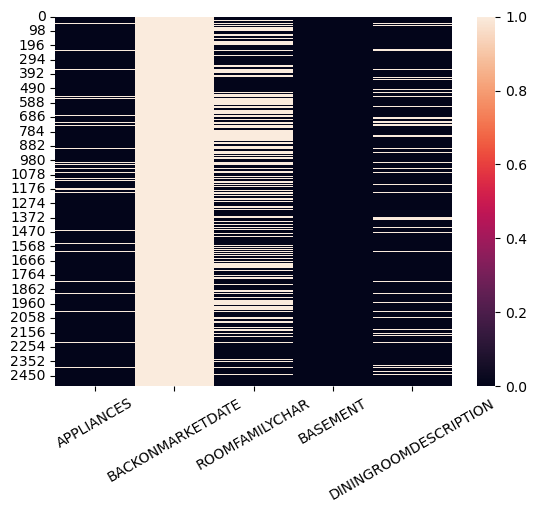

In [54]:
# Plot it
sns.heatmap(data=tf_df)
plt.xticks(rotation=30, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

### 6.8 Imputing Missing Data

In [55]:
# Count missing rows
# In this case there aren't nulls. But the way to input would be the same.
df.where(df['PDOM'].isNull()).count()

0

In [56]:
# Calculate the mean value
col_mean = df.agg({'PDOM': 'mean'}).collect()[0][0]

In [57]:
# Replacing with the mean value for that column
df.fillna(col_mean, subset=['PDOM'])

DataFrame[NO: bigint, MLSID: string, STREETADDRESS: string, STREETNAME: string, POSTALCODE: bigint, STATEORPROVINCE: string, CITY: string, SALESCLOSEPRICE: bigint, LISTDATE: string, LISTPRICE: bigint, LISTTYPE: string, ORIGINALLISTPRICE: bigint, PRICEPERTSFT: double, FOUNDATIONSIZE: bigint, FENCE: string, MAPLETTER: string, SCHOOLDISTRICTNUMBER: string, DAYSONMARKET: bigint, OFFMARKETDATE: string, FIREPLACES: bigint, ROOMAREA4: string, ROOMTYPE: string, ROOF: string, ROOMFLOOR4: string, POTENTIALSHORTSALE: string, POOLDESCRIPTION: string, PDOM: bigint, GARAGEDESCRIPTION: string, SQFTABOVEGROUND: bigint, TAXES: bigint, ROOMFLOOR1: string, ROOMAREA1: string, TAXWITHASSESSMENTS: double, TAXYEAR: bigint, LIVINGAREA: bigint, UNITNUMBER: string, YEARBUILT: bigint, ZONING: string, STYLE: string, ACRES: double, COOLINGDESCRIPTION: string, APPLIANCES: string, BACKONMARKETDATE: double, ROOMFAMILYCHAR: string, ROOMAREA3: string, EXTERIOR: string, ROOMFLOOR3: string, ROOMFLOOR2: string, ROOMAREA2:

In [58]:
# Count missing rows after imputing 
df.where(df['PDOM'].isNull()).count()

0

### 6.9 Calculate Missing Percents

We are going to create a function that will drop columns that have X percentage os missing values.

In [59]:
def column_dropper(df, threshold):
    # Takes a dataframe and threshold for missing values. Returns a dataframe.
    total_records = df.count()
    for col in df.columns:
    # Calculate the percentage of missing values
        missing = df.where(df[col].isNull()).count()
        missing_percent = missing / total_records
        # Drop column if percent of missing is more than threshold
        if missing_percent > threshold:
            df = df.drop(col)
    return df

In [60]:
#Number of columns before
print(len(df.columns))

79


In [61]:
# Drop columns that are more than 60% missing
df = column_dropper(df, .6)

In [62]:
#Number of columns after
print(len(df.columns))

73


# 7. Feature Engineering

### 7.1 Differences

In [63]:
# Lot size in square feet
acres_to_sqfeet = 43560
df = df.withColumn('LOT_SIZE_SQFT', df['ACRES'] * acres_to_sqfeet)

In [64]:
# Create new column YARD_SIZE
df = df.withColumn('YARD_SIZE', df['LOT_SIZE_SQFT'] - df['FOUNDATIONSIZE'])

In [65]:
# Corr of ACRES vs SALESCLOSEPRICE
print("Corr of ACRES vs SALESCLOSEPRICE: " + str(df.corr('ACRES', 'SALESCLOSEPRICE')))
# Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE
print("Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: " + str(df.corr('FOUNDATIONSIZE', 'SALESCLOSEPRICE')))
# Corr of YARD_SIZE vs SALESCLOSEPRICE
print("Corr of YARD_SIZE vs SALESCLOSEPRICE: " + str(df.corr('YARD_SIZE', 'SALESCLOSEPRICE')))

Corr of ACRES vs SALESCLOSEPRICE: 0.2130819260750225
Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: 0.5976957088401492
Corr of YARD_SIZE vs SALESCLOSEPRICE: 0.20032633979612804


### 7.2 Ratios

In [66]:
# ASSESSED_TO_LIST
df = df.withColumn('ASSESSED_TO_LIST', df['ASSESSEDVALUATION'] / df['LISTPRICE'])
df[['ASSESSEDVALUATION', 'LISTPRICE', 'ASSESSED_TO_LIST']].show(5)

+-----------------+---------+----------------+
|ASSESSEDVALUATION|LISTPRICE|ASSESSED_TO_LIST|
+-----------------+---------+----------------+
|              0.0|   139900|             0.0|
|              0.0|   210000|             0.0|
|              0.0|   225000|             0.0|
|              0.0|   230000|             0.0|
|              0.0|   239900|             0.0|
+-----------------+---------+----------------+
only showing top 5 rows



In [67]:
# TAX_TO_LIST
df = df.withColumn('TAX_TO_LIST', df['TAXES'] / df['LISTPRICE'])
df[['TAX_TO_LIST', 'TAXES', 'LISTPRICE']].show(5)

+--------------------+-----+---------+
|         TAX_TO_LIST|TAXES|LISTPRICE|
+--------------------+-----+---------+
|0.013280914939242315| 1858|   139900|
| 0.00780952380952381| 1640|   210000|
|0.010622222222222222| 2390|   225000|
|0.009330434782608695| 2146|   230000|
|0.008378491037932471| 2010|   239900|
+--------------------+-----+---------+
only showing top 5 rows



In [68]:
# BED_TO_BATHS
df = df.withColumn('BED_TO_BATHS', df['BEDROOMS'] / df['BATHSTOTAL'])
df[['BED_TO_BATHS', 'BEDROOMS', 'BATHSTOTAL']].show(5)

+------------------+--------+----------+
|      BED_TO_BATHS|BEDROOMS|BATHSTOTAL|
+------------------+--------+----------+
|               1.5|       3|         2|
|1.3333333333333333|       4|         3|
|               2.0|       2|         1|
|               1.0|       2|         2|
|               1.5|       3|         2|
+------------------+--------+----------+
only showing top 5 rows



### 7.3 Deeper Features

In [69]:
from scipy import stats

In [70]:
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

In [71]:
# Create new feature by adding two features together
df = df.withColumn('Total_SQFT', df['SQFTBELOWGROUND'] + df['SQFTABOVEGROUND'])

In [72]:
# Create additional new feature using previously created feature
df = df.withColumn('BATHS_PER_1000SQFT', df['BATHSTOTAL'] / (df['Total_SQFT'] / 1000))
df[['BATHS_PER_1000SQFT']].describe().show()

+-------+-------------------+
|summary| BATHS_PER_1000SQFT|
+-------+-------------------+
|  count|               4946|
|   mean| 1.4339460530042523|
| stddev| 14.205761576339642|
|    min|0.39123630672926446|
|    max|             1000.0|
+-------+-------------------+



In [73]:
# Sample and create pandas dataframe
pandas_df = df.sample(False, 0.5, 0).toPandas()

In [74]:
pandas_df=pandas_df[pandas_df["BATHS_PER_1000SQFT"]<1000]

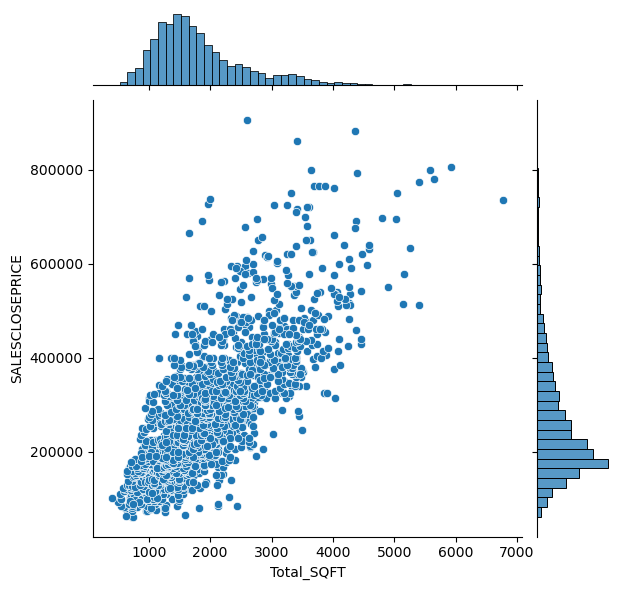

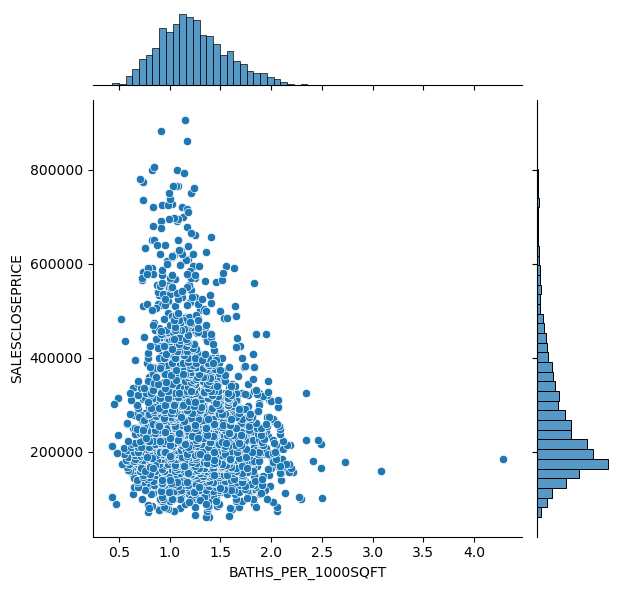

In [75]:
# Linear model plots
sns.jointplot(x='Total_SQFT', y='SALESCLOSEPRICE', data=pandas_df)
sns.jointplot(x='BATHS_PER_1000SQFT', y='SALESCLOSEPRICE', data=pandas_df)

### 7.4 Time Components

In [76]:

# Import needed functions
from pyspark.sql.functions import to_date, dayofweek

#Important to set this. If not, issues with datetime appear
my_spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

DataFrame[key: string, value: string]

In [77]:
# Convert to date type
df = df.withColumn('LISTDATE', to_date(df['LISTDATE'], format='MM/dd/yyyy HH:mm'))

In [78]:
# Get the day of the week
df = df.withColumn('List_Day_of_Week', dayofweek(df['LISTDATE']))

In [79]:
# Sample and convert to pandas dataframe
sample_df = df.sample(False, .5, 42).toPandas()

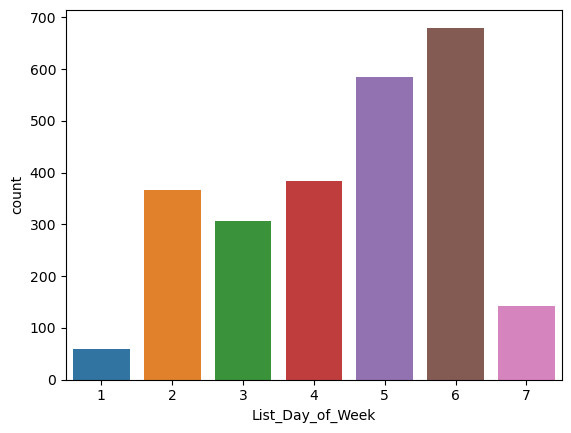

In [80]:
# Plot count plot of of day of week
sns.countplot(x="List_Day_of_Week", data=sample_df)
plt.show()

### 7.5 Joining On Time Components

In [81]:
import pandas as pd
data = dict(City=['LELM - Lake Elmo', 'MAPW - Maplewood','STP - Saint Paul','WB - Woodbury', \
                  'OAKD - Oakdale', 'LELM - Lake Elmo', 'MAPW - Maplewood', \
                  'STP - Saint Paul', 'WB - Woodbury', 'OAKD - Oakdale'],
     MedianHomeValue=[401000, 193000, 172000, 291000, 210000, 385000, 187000, 162000, 277000, 192000],
     Year= [2016,2016,2016,2016,2016,2015,2015,2015,2015, 2015])

In [82]:
df_price = pd.DataFrame(data)

In [83]:
price_df = my_spark.createDataFrame(df_price)
price_df.show()

+----------------+---------------+----+
|            City|MedianHomeValue|Year|
+----------------+---------------+----+
|LELM - Lake Elmo|         401000|2016|
|MAPW - Maplewood|         193000|2016|
|STP - Saint Paul|         172000|2016|
|   WB - Woodbury|         291000|2016|
|  OAKD - Oakdale|         210000|2016|
|LELM - Lake Elmo|         385000|2015|
|MAPW - Maplewood|         187000|2015|
|STP - Saint Paul|         162000|2015|
|   WB - Woodbury|         277000|2015|
|  OAKD - Oakdale|         192000|2015|
+----------------+---------------+----+



In [84]:
from pyspark.sql.functions import year

# Create year column
df = df.withColumn('list_year', year(df['LISTDATE']))

# Adjust year to match
df = df.withColumn('report_year', (df['list_year'] - 1))

In [85]:
# Create join condition
condition = [df['CITY'] == price_df['City'], df['report_year'] == price_df['year']]

# Join the dataframes together
df = df.join(price_df, on=condition, how='left')

In [86]:
# Inspect that new columns are available
df[['MedianHomeValue']].show()

+---------------+
|MedianHomeValue|
+---------------+
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
|         401000|
+---------------+
only showing top 20 rows



In [87]:
df[['MedianHomeValue']].describe().show()

+-------+------------------+
|summary|   MedianHomeValue|
+-------+------------------+
|  count|              4945|
|   mean|211631.95146612742|
| stddev|58960.469848766406|
|    min|            172000|
|    max|            401000|
+-------+------------------+



### 7.6 Date Math

In [88]:
from pyspark.sql.functions import lag, datediff, to_date
from pyspark.sql.window import Window

In [89]:
# Cast data type
mort_df = df.withColumn('DATE', to_date(df['LISTDATE']))

In [90]:
# Create window
w = Window().orderBy(mort_df['DATE'])
# Create lag column
mort_df = mort_df.withColumn('DATE-1', lag(mort_df['DATE'], offset=1).over(w))

In [91]:
mort_df.select(['DATE','DATE-1']).show(10)

+----------+----------+
|      DATE|    DATE-1|
+----------+----------+
|2017-02-23|      null|
|2017-02-24|2017-02-23|
|2017-02-24|2017-02-24|
|2017-02-24|2017-02-24|
|2017-02-24|2017-02-24|
|2017-02-24|2017-02-24|
|2017-02-24|2017-02-24|
|2017-02-24|2017-02-24|
|2017-02-24|2017-02-24|
|2017-02-24|2017-02-24|
+----------+----------+
only showing top 10 rows



In [92]:
# Calculate difference between date columns
mort_df = mort_df.withColumn('Days_Between_Report', datediff(mort_df['DATE'], mort_df['DATE-1']))

In [93]:
mort_df.select(['DATE','DATE-1',"Days_Between_Report"]).show(10)

+----------+----------+-------------------+
|      DATE|    DATE-1|Days_Between_Report|
+----------+----------+-------------------+
|2017-02-23|      null|               null|
|2017-02-24|2017-02-23|                  1|
|2017-02-24|2017-02-24|                  0|
|2017-02-24|2017-02-24|                  0|
|2017-02-24|2017-02-24|                  0|
|2017-02-24|2017-02-24|                  0|
|2017-02-24|2017-02-24|                  0|
|2017-02-24|2017-02-24|                  0|
|2017-02-24|2017-02-24|                  0|
|2017-02-24|2017-02-24|                  0|
+----------+----------+-------------------+
only showing top 10 rows



In [94]:
# Print results
mort_df.select('Days_Between_Report').distinct().show()

+-------------------+
|Days_Between_Report|
+-------------------+
|               null|
|                  1|
|                  0|
|                  2|
|                  3|
|                  9|
|                 12|
+-------------------+



### 7.7 Extracting Text to New Features

In [95]:
# Import needed functions
from pyspark.sql.functions import when

In [96]:
# Create boolean conditions for string matches
has_attached_garage = df['GARAGEDESCRIPTION'].like('%Attached%')
has_detached_garage = df['GARAGEDESCRIPTION'].like('%Detached%')


In [97]:
# Conditional value assignment 
df = df.withColumn('has_attached_garage', (when(has_attached_garage, 1)
                                          .when(has_detached_garage, 0)
                                          .otherwise(None)))


In [98]:
# Inspect results
df[['GARAGEDESCRIPTION', 'has_attached_garage']].show(truncate=100)

+------------------------------------------------------------------+-------------------+
|                                                 GARAGEDESCRIPTION|has_attached_garage|
+------------------------------------------------------------------+-------------------+
|                                                   Attached Garage|                  1|
|           Attached Garage, Driveway - Asphalt, Garage Door Opener|                  1|
|                                                   Attached Garage|                  1|
|    Attached Garage, Detached Garage, Tuckunder, Driveway - Gravel|                  1|
|           Attached Garage, Driveway - Asphalt, Garage Door Opener|                  1|
|                               Attached Garage, Driveway - Asphalt|                  1|
|           Attached Garage, Driveway - Asphalt, Garage Door Opener|                  1|
|                                                   Attached Garage|                  1|
|                    

### 7.8 Splitting & Exploding

In [99]:
df.select(['GARAGEDESCRIPTION']).show(truncate=100)

+------------------------------------------------------------------+
|                                                 GARAGEDESCRIPTION|
+------------------------------------------------------------------+
|                                                   Attached Garage|
|           Attached Garage, Driveway - Asphalt, Garage Door Opener|
|                                                   Attached Garage|
|    Attached Garage, Detached Garage, Tuckunder, Driveway - Gravel|
|           Attached Garage, Driveway - Asphalt, Garage Door Opener|
|                               Attached Garage, Driveway - Asphalt|
|           Attached Garage, Driveway - Asphalt, Garage Door Opener|
|                                                   Attached Garage|
|                                                   Attached Garage|
|                                                   Attached Garage|
|                                                   Attached Garage|
|                                 

In [100]:
# Import needed functions
from pyspark.sql.functions import split, explode

# Convert string to list-like array
df = df.withColumn('garage_list', split(df['GARAGEDESCRIPTION'], ', '))

# Explode the values into new records
ex_df = df.withColumn('ex_garage_list', explode(df['garage_list']))

# Inspect the values
ex_df[['ex_garage_list']].distinct().show(100, truncate=50)

+----------------------------+
|              ex_garage_list|
+----------------------------+
|             Attached Garage|
|      On-Street Parking Only|
|                        None|
| More Parking Onsite for Fee|
|          Garage Door Opener|
|   No Int Access to Dwelling|
|           Driveway - Gravel|
|       Valet Parking for Fee|
|              Uncovered/Open|
|               Heated Garage|
|          Underground Garage|
|                       Other|
|                  Unassigned|
|More Parking Offsite for Fee|
|    Driveway - Other Surface|
|       Contract Pkg Required|
|                     Carport|
|                     Secured|
|             Detached Garage|
|          Driveway - Asphalt|
|                  Units Vary|
|                    Assigned|
|                   Tuckunder|
|                     Covered|
|            Insulated Garage|
|         Driveway - Concrete|
|                      Tandem|
|           Driveway - Shared|
+----------------------------+



In [101]:
df.count()

4946

In [102]:
ex_df.count()

11097

### 7.9 Pivot & Join

In [105]:
from pyspark.sql.functions import coalesce, first, lit

# Create a dummy column of constant value
ex_df = ex_df.withColumn('constant_val', lit(1))

# Pivot 
piv_df = ex_df.groupBy('NO').pivot('ex_garage_list').agg(coalesce(first('constant_val')))

# Join the dataframes together and fill null
joined_df = df.join(piv_df, on='NO', how='left')

# Columns to zero fill
zfill_cols = piv_df.columns

# Zero fill the pivoted values
zfilled_df = joined_df.fillna(0, subset=zfill_cols)

Sources:
https://github.com/ozlerhakan/datacamp/blob/master/Feature%20Engineering%20with%20PySpark/Feature%20Engineering%20with%20PySpark.ipynb